Yichen Duan

Zihao Mao

Cameron Matson


11/20/2017

# Lab 7: CNNs

## Introduction

For this lab we examine the images of the Stanford Dog Dataset.  The dataset consits of ~20,000 images of dogs from 120 different breeds.

#### Issues
The dataset is primarily used for fine-grained classification problems, meaning that the instances are all members of the same main class and are divided by subclass.  In this case, the main class is 'Dog' and the subclass is the breed: 'Beagle', 'Poodle', 'Lab'...  These are potentially more difficult than standard classification problems because in theory all members of teh main class should at least share similar features.  In other words as the saying goes "a dog is a dog is a dog not a cat."

Another challenge with this dataset is that there is that they do not depict a standard scene.  These are not faces of dogs.  These are not photoshoot photos of dogs.  The images in the dataset are not even exclusively of dogs.  Some contain multiple dogs or even people.  The dataset would benefit from preprocessing in the form of some sort of standardization such that all the images are of the same kind, using facial detection for instance.

#### Uses
Some possible uses of this type of classification: maybe a city or some other community has had a problem recently with a particular breed of dog acting violently towards humans, this system could be used on video footage (from a source like street cameras) in an attempt to identify areas where these dogs are.  Another use could be by the American Kennel Club in order to help them identify dog breeds when registering dogs without previous paperwork.  Maybe the could use the system as a preliminary step to shrink down the number of applications.  Or maybe there is an online marketplace for person to person pet sales that wants to ensure that the sellers are reliably posting the breeds that the claim.

#### Metric
In both of the cases above a high level of accuracy would be required for it to replace a human classifier.  People, especially ones who work in Animal Control or for the AKC are likely to be pretty good at identifying dogs.  Therefore to make the system as useful as possible we'd like it to have as low a false negative rate as possible, this way the human user would only be tasked with identifying false positives.  Therefore we will use recall as our metric, specifically the micro-averaged recall, because we're particularly concerned with minimizing the number of false negatives for each class.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.misc import imresize
from skimage.color import rgb2gray
%matplotlib inline
# for zihao
imagedir = '../img_data/dogs/Images'
# for cameron
#imagedir = '../../data/dogs'

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import average 
from keras.models import Input, Model
from keras.regularizers import l2

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics as mt

import numpy as np

keras.__version__

Using TensorFlow backend.


'2.0.9'

## Data Preprocessing

There are 120 different breeds included in the dataset with bout 150 images of each breed for a total of 20,580 images.  The images are stored in directories by breed.  To make the size of the dataset more managable, we're only going to select 5 particular breeds.

In [3]:
# remove dsstore
for d in os.listdir(imagedir):
    if d.find('.DS') != -1:
        os.remove(os.path.join(imagedir,d))
        continue
    for f in os.listdir(os.path.join(imagedir, d)):
        if f.find('.DS') != -1:
            os.remove(os.path.join(imagedir,d,f))
    

In [4]:
def load_images(num_classes, h, w):
    
    # preinitialize the matrix
    #img_arr = np.empty((num_samples_per_breed*num_breeds,h*w))  # 20 instances of each breed, each img will be 200x200 = 40000 pixels
    img_arr = []
    label_arr = []
    
    # sample 60 breeds from the dataset
    a = np.arange(len(os.listdir(imagedir)))
    np.random.shuffle(a)
    breed_sample_idxs = a[:num_classes]
    for i, idx in enumerate(breed_sample_idxs):
        breed = os.listdir(imagedir)[idx]
        if breed[0] == '.' : 
            continue # stupid ds.store on mac
        print(i,breed)
        
        for img in os.listdir(os.path.join(imagedir, breed)):
            dog_path = os.path.join(imagedir,breed,img)            

            img = plt.imread(dog_path)
            
            # converts image to gray, resizes it to be 200x200, and then linearizes it
            img_gray_resize_flat = rgb2gray(imresize(img, (h,w,3))).flatten()
                        
            img_arr.append(img_gray_resize_flat)

            # add name to list of labels
            fname = dog_path.split('/')[-1] # 'dog_name_123497.jpg'
            dog_name = fname[:fname.rfind('_')] # 'dog_name'
            label_arr.append(breed)
            
    return img_arr, label_arr

In [5]:
%%time
num_breeds = 5
h=128
w=128

dogs, labels = load_images(num_classes=num_breeds, h=h, w=w)
print(len(dogs))

0 Japanese_spaniel
1 Tibetan_mastiff
2 komondor
3 Ibizan_hound
4 German_short
831
Wall time: 6.43 s


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df= pd.DataFrame(dogs)

X = np.array(dogs)

enc = LabelEncoder()
y = enc.fit_transform(labels)

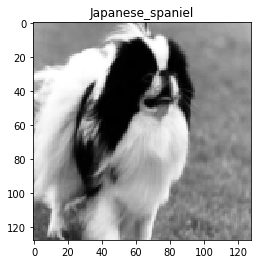

In [7]:
ex = dogs[0].reshape((h,w))
plt.imshow(ex, cmap='gray')
plt.title(labels[0])
plt.show()

Let's do a quick check of the distribution of breeds that we're using.

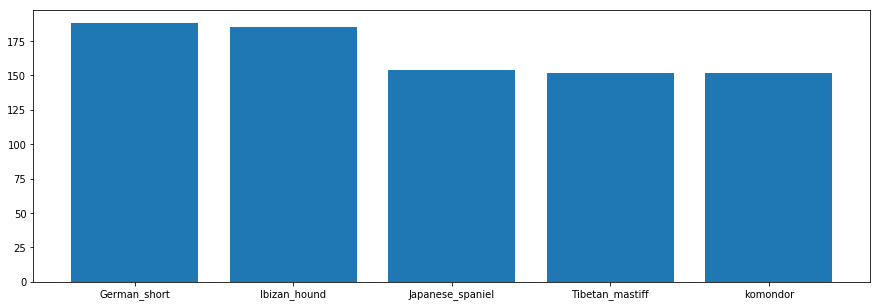

In [8]:
plt.figure(figsize=(15, 5))
plt.bar(list(set(y)), pd.Series(y).value_counts())
plt.xticks(np.arange(5), enc.classes_)
plt.show()

As was stated previously the distribution betwewen classes is nearly uniform.

### Cross Validation Scheme

Since these networks take SOO long to train and we don't have that much data, we're  going to use a 3-fold cross-validation set up.  K-fold because we can't afford to not train on all of thee data, and 3 folds so we can finish on time.  We'll also use stratified folds to be safe even though our breed distribution is pretty uniform.  After we train the 3 models we'll be able to look at the average performance to get a sense of how the model might perform once deployed.

First we'll define 3 functions to perform three different architectures, a regular MLP, a basic CNN (a few convolutions followed by a few dense layers), and an Ensemble Net style architecture.

In [9]:
# some constants we'll need
img_hw = 128
img_wh = 128
l2_lambda = 0.001

NUM_CLASSES = 5

## MLP

In [10]:
def do_mlp(X_train, y_train, X_test, y_test):
    # make a 3 layer keras MLP
    mlp = Sequential()
    mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add( Dense(units=30, activation='relu') )
    mlp.add( Dense(NUM_CLASSES) )
    mlp.add( Activation('softmax') )

    mlp.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    mlp.fit(X_train, y_train, 
            batch_size=32, epochs=100, 
            shuffle=True, verbose=1)
    
    yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
    
    return mlp, mt.recall_score(y_test,yhat_mlp, average='micro')

## cnn1: simple

In [11]:
def do_cnn1(X_train, y_train, X_test, y_test, y_test_ohe):
    cnn_layers = [32, 16]

    # make a CNN with conv layer and max pooling
    cnn = Sequential()
    cnn.add(Reshape((1, 128, 128), input_shape=(1,128*128)))

    for n in cnn_layers:
        cnn.add(Conv2D(filters=n, kernel_size= (3, 3), padding='same', input_shape=(1, h,w), data_format='channels_first'))
        cnn.add(Activation('relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    # add one layer on flattened output
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())

    cnn.add(Dropout(0.25))
    cnn.add(Dense(80))
    cnn.add(Activation('relu'))

    cnn.add(Dropout(0.50))
    cnn.add(Dense(20))
    cnn.add(Activation('relu'))


    cnn.add(Dense(NUM_CLASSES))
    cnn.add(Activation('softmax'))


    # Let's train the model 
    cnn.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    cnn.fit(np.expand_dims(X_train, axis = 1), y_train, 
            batch_size=32, epochs=10,
            validation_data=((np.expand_dims(X_test, axis=1), y_test_ohe)),
            shuffle=True, verbose=1)
    
    yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
    
    rec = mt.recall_score(y_pred=yhat_cnn, y_true=y_test, average='micro')
    return cnn, rec

## cnn2:  Ensemble Net

In [12]:
def do_ensemble(X_train, y_train, X_test, y_test):


    num_ensembles = 3

    input_holder = Input(shape=(img_wh, img_wh, 1))

    branches = []
    for _ in range(num_ensembles):

        conv1 = Conv2D(filters=32,
                       input_shape = (img_wh,img_wh,1),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(input_holder)

        max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

        conv2 = Conv2D(filters=32,
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu',data_format="channels_last")(max1)

        max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


        # add one layer on flattened output
        drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
        flat1 = Flatten()(drop1)
        dense1 = Dense(128, 
                      activation='relu',
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_lambda)
                    )(flat1)
        drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
        dense2 = Dense(NUM_CLASSES, 
                      activation='sigmoid', 
                      kernel_initializer='glorot_uniform',
                      kernel_regularizer=l2(l2_lambda)
                     )(drop2)

        # now add this branch onto the master list
        branches.append(dense2)

    # that's it, we just need to average the results
    ave = average(branches)

    # here is the secret sauce for setting the network using the 
    #   Model API:
    cnn_ens = Model(inputs=input_holder,outputs=ave)

    # Let's train the model 
    cnn_ens.compile(loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='rmsprop', # 'adadelta' 'rmsprop'
                    metrics=['accuracy'])
    X_train = np.expand_dims(X_train.reshape(-1,img_hw,img_hw), axis=3)
    X_test = np.expand_dims(X_test.reshape(-1,img_hw,img_hw), axis=3)
    # the flow method yields batches of images indefinitely, with the given transofmrations
    cnn_ens.fit(X_train, y_train, 
            batch_size=32, epochs=10,
            shuffle=True, verbose=1)
    yhat = np.argmax(cnn_ens.predict(X_test), axis=1)
    rec = mt.recall_score(y_test,yhat, average='micro')
    
    return cnn_ens, rec

And now for the loop...

In [13]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

N_SPLITS = 3

cnn1_rec = []
cnn2_rec = []
mlp_rec = []

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=0, shuffle=False)
for i, (train, test) in enumerate(skf.split(X, y)):
    # split up the data
    X_train = X[train]
    y_train = y[train]
    
    X_test = X[test]
    y_test = y[test]
    
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
    
    # architecture 1
    print('\ntraining fold', i+1, 'cnn 1')
    cnn1, cnn1_result = do_cnn1(X_train, y_train_ohe, X_test, y_test, y_test_ohe)
    cnn1_rec.append(cnn1_result)
    print('fold', i+1, 'cnn1 recall score: ', cnn1_result)
    
    # architecture 2
    print('\ntraining fold', i+1, 'cnn 2')
    cnn2, cnn2_result = do_ensemble(X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train_ohe)
    cnn2_rec.append(cnn2_result)
    print('fold', i+1, 'cnn2 recall score: ', cnn2_result)
        
    # MLP
    print('\ntraining fold', i+1, 'mlp')
    mlp, mlp_result = do_mlp(X_train, y_train_ohe, X_test, y_test)
    mlp_rec.append(mlp_result)
    print('fold', i+1, 'mlp recall score: ', mlp_result)



training fold 1 cnn 1
Train on 552 samples, validate on 279 samples
Epoch 1/10
552/552 [==============================] - 21s 38ms/step - loss: 0.1640 - acc: 0.2337 - val_loss: 0.1595 - val_acc: 0.2330
Epoch 2/10
552/552 [==============================] - 21s 38ms/step - loss: 0.1589 - acc: 0.2609 - val_loss: 0.1602 - val_acc: 0.2616
Epoch 3/10
552/552 [==============================] - 21s 38ms/step - loss: 0.1560 - acc: 0.3279 - val_loss: 0.1497 - val_acc: 0.3907
Epoch 4/10
552/552 [==============================] - 20s 37ms/step - loss: 0.1400 - acc: 0.4402 - val_loss: 0.1501 - val_acc: 0.3369
Epoch 5/10
552/552 [==============================] - 20s 37ms/step - loss: 0.1365 - acc: 0.4348 - val_loss: 0.1343 - val_acc: 0.4480
Epoch 6/10
552/552 [==============================] - 21s 37ms/step - loss: 0.1248 - acc: 0.5326 - val_loss: 0.1406 - val_acc: 0.4624
Epoch 7/10
552/552 [==============================] - 21s 37ms/step - loss: 0.1140 - acc: 0.5543 - val_loss: 0.1330 - val_acc: 

553/553 [==============================] - 0s 275us/step - loss: 0.3027 - acc: 0.2043
Epoch 16/100
553/553 [==============================] - 0s 276us/step - loss: 0.2289 - acc: 0.2152
Epoch 17/100
553/553 [==============================] - 0s 278us/step - loss: 0.2525 - acc: 0.2459
Epoch 18/100
553/553 [==============================] - 0s 271us/step - loss: 0.2238 - acc: 0.2803
Epoch 19/100
553/553 [==============================] - 0s 275us/step - loss: 0.2115 - acc: 0.3219
Epoch 20/100
553/553 [==============================] - 0s 279us/step - loss: 0.1757 - acc: 0.2893
Epoch 21/100
553/553 [==============================] - 0s 273us/step - loss: 0.1605 - acc: 0.3400
Epoch 22/100
553/553 [==============================] - 0s 276us/step - loss: 0.1568 - acc: 0.3472
Epoch 23/100
553/553 [==============================] - 0s 273us/step - loss: 0.1553 - acc: 0.3544
Epoch 24/100
553/553 [==============================] - 0s 279us/step - loss: 0.1461 - acc: 0.3834
Epoch 25/100
553/553 [=

557/557 [==============================] - 0s 278us/step - loss: 0.0977 - acc: 0.6391
Epoch 55/100
557/557 [==============================] - 0s 276us/step - loss: 0.1048 - acc: 0.6086
Epoch 56/100
557/557 [==============================] - 0s 275us/step - loss: 0.0985 - acc: 0.6373
Epoch 57/100
557/557 [==============================] - 0s 279us/step - loss: 0.0971 - acc: 0.6427
Epoch 58/100
557/557 [==============================] - 0s 275us/step - loss: 0.0939 - acc: 0.6481
Epoch 59/100
557/557 [==============================] - 0s 281us/step - loss: 0.0979 - acc: 0.6463
Epoch 60/100
557/557 [==============================] - 0s 278us/step - loss: 0.0942 - acc: 0.6499
Epoch 61/100
557/557 [==============================] - 0s 280us/step - loss: 0.0963 - acc: 0.6589
Epoch 62/100
557/557 [==============================] - 0s 276us/step - loss: 0.0956 - acc: 0.6373
Epoch 63/100
557/557 [==============================] - 0s 274us/step - loss: 0.0961 - acc: 0.6248
Epoch 64/100
557/557 [=

## so how did it do....

Below are the general statistics from the cross validation

In [14]:
print('stats:')
print('*'*6)
print('mlp:', np.mean(mlp_rec), '+-', np.std(mlp_rec))
print('cnn1:', np.mean(cnn1_rec), '+-', np.std(cnn1_rec))
print('cnn2:', np.mean(cnn2_rec), '+-', np.std(cnn2_rec))

stats:
******
mlp: 0.409615138123 +- 0.0669454775237
cnn1: 0.539085221894 +- 0.0210491626768
cnn2: 0.410111593639 +- 0.0390237351274


It looks like the simple architecture performed the best, its over two standard deviations greater than either of the other two models.  And with a standard deviation of only 2% we can assume this is about how well it would perform once deployed.  The overall recall score of 53% isn't great, but it actually lines up pretty well with these published results:
http://vision.stanford.edu/aditya86/ImageNetDogs/
granted we are looking at only 5 classes, but we're also probably not training nearly as long.


We can also look at the confusion matrix for the final instance of each of the architecture's, to see where its getting things right and wrong.

In [15]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn1, cnn2, mlp, X_test, y_test, enc):
    plt.figure(figsize=(20,5))
    if cnn1 is not None:
        yhat_cnn1 = np.argmax(cnn1.predict(np.expand_dims(X_test, axis=1)), axis=1)
        rec_cnn1 = mt.recall_score(y_test,yhat_cnn1, average='micro')
        plt.subplot(1,3,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn1)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN1: '+str(rec_cnn1))
    
    if cnn2 is not None:
        yhat_cnn2 = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
        rec_cnn2 = mt.recall_score(y_test,yhat_cnn2, average='micro')
        plt.subplot(1,3,2)
        cm = mt.confusion_matrix(y_test,yhat_cnn2)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN2: '+str(rec_cnn2))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        rec_mlp = mt.recall_score(y_test,yhat_mlp, average='micro')
        plt.subplot(1,3,3)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('MLP: '+str(rec_mlp))

\*for some reason the ensemble net is not playing nicely with the following visualizations so we'll skip them, but the above results indicate that it didn't perform much better than the standard multi-level perceptron.\*

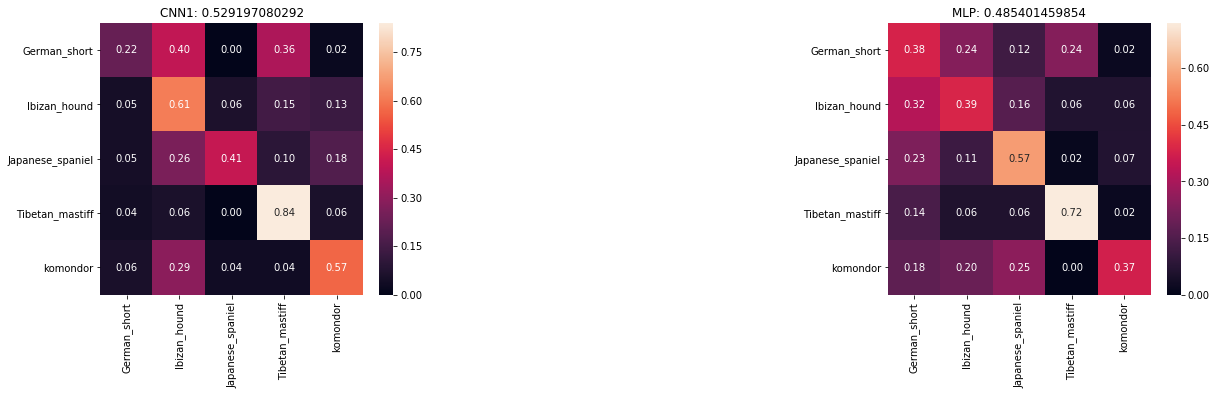

In [20]:
#compare_mlp_cnn(cnn1, cnn2, mlp, X_test, y_test, enc)
compare_mlp_cnn(cnn1, None, mlp, X_test, y_test, enc)

You can see that both networks do pretty well at identifying the mastiff, which makes sense as it is pretty unique looking among these 5 breeds in terms of its size, coloring, and coat style.  For both architectures the model correctly identified the breed the majority of the time, although the cnn did better on 4/5 of the breeds.

We can also look at the ROC curve for each architecture.  Again, we'll just use the last fold, but since the standard deviation on the cross-validation is small it should give a fairly good estimation.  The roc interpolates trade off between false positives and true positives, while the area under the curve gives a pretty good estimation of the general performance of the model--the closer it is to 1, the better the model performs.

166/166 [==============================] - 3s 16ms/step


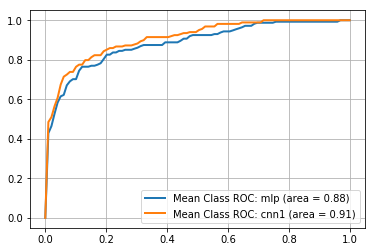

In [21]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

perclass_mean_tpr = 0.0
roc_auc = 0

# we'll just grab a random 20 % of the samples
idx = np.random.randint(0, len(X), size=int(len(X)/5))
X_hm = X[idx]
y_hm = y[idx]

probas_mlp = mlp.predict_proba(X_hm)
probas_cnn1 = cnn1.predict_proba(np.expand_dims(X_hm, axis=1))
#probas_cnn2 = cnn2.predict_proba(np.expand_dims(X_hm, axis=1))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

#for arch in ['mlp', 'cnn1', 'cnn2']:
for arch in ['mlp', 'cnn1']:
    probas = eval('probas_'+arch)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_test)
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_hm,
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,lw=2,label = 'Mean Class ROC: %s (area = %0.2f)'
                   % (arch, roc_auc))
    
plt.legend(loc='best')
plt.grid()

\*the ensemble net doesn't play nice with this function because it uses the functional model and doesn't implement the `predict_proba` function\*

We can see that again the cnn1 edges out slightly the mlp:  it has a higher AUC and the ROC is uniformly above the mlp's curve.

## With more data

Now we'll use the `ImageDataGenerator` module as part of Keras to exand the dataset using our top performing architecture.  The data expansion should do two things, 1) improve the training of the model by simply providing more data, and 2) imporve generaliztion performance, because the generator introduces noise into the system that acts as a regularization technique.

In [23]:
from keras.preprocessing.image import ImageDataGenerator


In [24]:
# we need to redefine our train and test splits
X = X.reshape(-1,img_hw,img_hw)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

We need to redefine some of our functions to work with the generator.

In [25]:
# the datagenerator does the reshaping for us so we need to redefine the cnn model
cnn = Sequential()

# no reshape here!

cnn.add(Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

In [26]:
# the flow method yields batches of images indefinitely, with the given transofmrations
cnn.fit_generator(datagen.flow(np.expand_dims(X_train, axis = 3), y_train_ohe, batch_size=128), 
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=10, verbose=1,
                  validation_data=(np.expand_dims(X_test, axis = 3),y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

Epoch 1/10
5/5 [==============================] - 7s 1s/step - loss: 9.8439 - acc: 0.2153 - val_loss: 10.1003 - val_acc: 0.1796
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 4.5001 - acc: 0.2331 - val_loss: 1.8488 - val_acc: 0.3473
Epoch 3/10
5/5 [==============================] - 7s 1s/step - loss: 1.8659 - acc: 0.3047 - val_loss: 1.7883 - val_acc: 0.3533
Epoch 4/10
5/5 [==============================] - 5s 1s/step - loss: 1.8073 - acc: 0.3475 - val_loss: 1.7778 - val_acc: 0.3593
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 1.7458 - acc: 0.3564 - val_loss: 1.7177 - val_acc: 0.3713
Epoch 6/10
5/5 [==============================] - 7s 1s/step - loss: 1.7344 - acc: 0.3781 - val_loss: 1.6333 - val_acc: 0.4491
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 1.6696 - acc: 0.3968 - val_loss: 1.5888 - val_acc: 0.4491
Epoch 8/10
5/5 [==============================] - 6s 1s/step - loss: 1.6882 - acc: 0.3710 - val_loss: 1.5814 -

In [27]:
# finally we also need to redefine the viz function
def compare_mlp_cnn(cnn1, X_test, y_test, enc):
    plt.figure(figsize=(20,5))
    if cnn1 is not None:
        yhat_cnn1 = np.argmax(cnn1.predict( np.expand_dims(X_test.reshape(-1, img_hw,img_hw), axis=3)), axis=1)
        rec_cnn1 = mt.recall_score(y_test,yhat_cnn1, average='micro')
        plt.subplot(1,3,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn1)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN1: '+str(rec_cnn1))

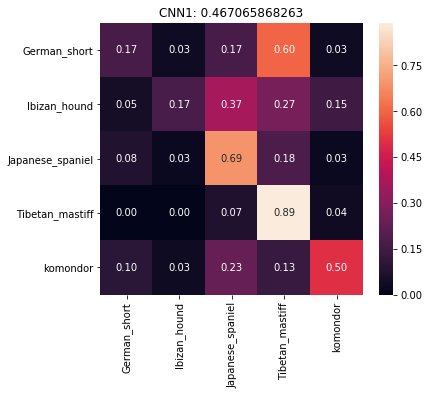

In [28]:
compare_mlp_cnn(cnn, X_test, y_test, enc)

The overall performance actually went down, but not by two much.  We didn't run this in a cross-validation loop so we can't be sure wether this is a general result or not, but its within 2 std of the previous result so it very well could be.